In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)

In [3]:
company=pandas.read_csv("./dataset/diversity/company_hierarchy.csv")

In [4]:
company.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [5]:
company.describe(include='all')

,employee_id,boss_id,dept
count,10000.000000,9999.000000,10000
unique,NaN,NaN,5
top,NaN,NaN,sales
freq,NaN,NaN,3599
mean,100001.855800,103299.980498,NaN
std,57500.488641,57508.798817,NaN
min,40.000000,79.000000,NaN
25%,50574.500000,55883.000000,NaN
50%,99244.500000,102712.000000,NaN
75%,149748.500000,152288.000000,NaN


In [6]:
employee=pandas.read_csv("./dataset/diversity/employee.csv")

In [7]:
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [8]:
employee.describe(include='all')

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
count,10000.000000,10000.000000,10000.000000,10000,10000,10000.000000
unique,NaN,NaN,NaN,4,2,NaN
top,NaN,NaN,NaN,PhD,M,NaN
freq,NaN,NaN,NaN,2822,6439,NaN
mean,100001.855800,0.301400,189111.800000,NaN,NaN,3.875200
std,57500.488641,0.458889,88973.796898,NaN,NaN,3.107409
min,40.000000,0.000000,60000.000000,NaN,NaN,1.000000
25%,50574.500000,0.000000,110000.000000,NaN,NaN,2.000000
50%,99244.500000,0.000000,182000.000000,NaN,NaN,3.000000
75%,149748.500000,1.000000,255000.000000,NaN,NaN,5.000000


Q: In the company there are 6 levels :
Individual Contributors(IC) - they don’t manage anyone
Middle Managers(MM) - they are the direct bosses of IC
Directors(D) - they are the direct bosses of MM
VP - D direct bosses
Executives (E) - VP direct bosses
CEO - The direct boss of E.

Identify, for each employee, her corresponding level.

There is only one CEO in the company and that can be found right away because has no boss (or the dept is “CEO”) . Once the CEO has been identified, we can identify Executives (these are people reporting to the CEO) and so on all the way down to the ICs.

In [9]:
#At first, we set everyone as IC, then we keep updating this vector
company['level'] = "IC"
  
#identify the CEO
company.loc[company.dept == "CEO", "level"] = "CEO"
  
#assign everyone else based on their boss level
company_levels = ["CEO", "E", "VP", "D", "MM"]


In [10]:
for i in range(1,len(company_levels)):
  #identify IDs of the boss. This is employee ID of the level above
  boss_id = company.loc[company.level == company_levels[i-1], 'employee_id']
  company.loc[company.boss_id.isin(boss_id), "level"] = company_levels[i]


In [11]:
#frequency
print(company.level.value_counts())


IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64


Q: How many people each employee manages? Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

Here we will use the opposite approach: we start from the bottom (IC) and then count all the way up to the CEO.


In [12]:
#At first, we set 0. This will be true for ICs, then we keep updating this vector for all others
company['num_reports'] = 0
  
#same as before, but now we start from the bottom
company_levels = ["IC", "MM", "D", "VP", "E"]
  
i=0
while i<len(company_levels):
  #this is the count of direct reports + the prior count so we take into account direct reports of direct reports, etc.
  level_count=company.loc[company.level == company_levels[i]].groupby('boss_id')['num_reports'].agg(lambda x: x.count() + x.sum())
                                         
  #join to the main table to get the new report count for the bosses from the step above
  company=pandas.merge(left=company, right=level_count, how='left', left_on="employee_id", right_on="boss_id", suffixes=('', '_updated'))
  company['num_reports'] = company.num_reports_updated.combine_first(company.num_reports)
  #we can delete this now that we have updated the count
  del company['num_reports_updated']
  i+=1


In [13]:
company.sort_values(by=['num_reports'], ascending=False).head()

,employee_id,boss_id,dept,level,num_reports
2427,61554,NaN,CEO,CEO,9999.0
1310,11277,61554.0,sales,E,3598.0
2778,51535,61554.0,engineering,E,2695.0
1009,110464,61554.0,marketing,E,2009.0
9640,93708,61554.0,HR,E,1693.0


Build a model to predict the salary of each employee

In [14]:
employee.head(1)

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2


In [15]:
#Let's join the two datasets
data=pandas.merge(left=company, right=employee)

In [16]:
data.head()

,employee_id,boss_id,dept,level,num_reports,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456,175361.0,sales,IC,0.0,0,213000.0,Bachelor,M,5
1,104708,29733.0,HR,IC,0.0,0,79000.0,Bachelor,F,3
2,120853,41991.0,sales,IC,0.0,0,199000.0,High_School,M,5
3,142630,171266.0,HR,MM,16.0,0,143000.0,PhD,F,13
4,72711,198240.0,sales,IC,0.0,0,235000.0,Master,M,1


In [17]:
#And get rid of the columns we don't care about, i.e. the IDs and CEO, which is just one row so hardly useful
#data=data.query("dept!=\"CEO\"").drop(["employee_id","boss_id"], axis=1)
data=data.query('dept!="CEO"').drop(["employee_id","boss_id"], axis=1)

In [18]:
data.head()

,dept,level,num_reports,signing_bonus,salary,degree_level,sex,yrs_experience
0,sales,IC,0.0,0,213000.0,Bachelor,M,5
1,HR,IC,0.0,0,79000.0,Bachelor,F,3
2,sales,IC,0.0,0,199000.0,High_School,M,5
3,HR,MM,16.0,0,143000.0,PhD,F,13
4,sales,IC,0.0,0,235000.0,Master,M,1


In [19]:
#Level and degree are actually conceptually ordered. So in this case it can make sense to replace them with numbers that represent the rank
codes = {"High_School":1, "Bachelor":2, "Master":3, "PhD":4}
data['degree_level'] = data['degree_level'].map(codes)
  
codes = {"IC":1, "MM":2, "D":3,"VP":4, "E":5}
data['level'] = data['level'].map(codes)
  
#Let's make sex numerical manually
data['is_male'] = np.where(data['sex']=='M', 1,  0)
del data['sex']

Most of the variables in this dataset are likely correlated. For instance, level in the company is likely correlated with number of reports or yrs of experience. We could pre-process and clean the data before building a model. However, a simpler choice is to use a Random Forest, which is known to work well out of the box in those cases.

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
np.random.seed(1234)
  
#dummy variables for the categorical one, i.e. dept. We keep all levels here. It is not going to affect RF badly, after all it does well with correlated variables and it is just one variable with few levels. And this is going to make insights much cleaner
data_dummy = pandas.get_dummies(data)
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_dummy, test_size = 0.34)  

In [21]:
# will use standard params here. They are likely close to optimal and changing them won't make much of a different in terms of insights, which is our goal here
rf = RandomForestRegressor(oob_score=True, n_estimators = 100)
rf.fit(train.drop('salary', axis=1), train['salary'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [22]:
print("MSE on OOB is", metrics.mean_squared_error(train['salary'], rf.oob_prediction_).round(), "and on test set is", metrics.mean_squared_error(test['salary'], rf.predict(test.drop('salary', axis=1))).round())


MSE on OOB is 5653838615.0 and on test set is 5785077483.0


In [23]:
print("% explained variance on OOB is", metrics.explained_variance_score(train['salary'], rf.oob_prediction_).round(2), "and on test set is", metrics.explained_variance_score(test['salary'], rf.predict(test.drop('salary', axis=1))).round(2))

% explained variance on OOB is 0.28 and on test set is 0.28


It is always hard to understand exactly what % of variance explained means, especially from a product standpoint. On top of that, that number is not only a function of how good our model is, but also depends on how much variance the starting dataset had. So it is hardly informative. The good news though is that for sure the model is not over-fitting.
Let’s try to turn this into something a bit more concrete. Let’s use as a metric proportion of salaries for which the prediction is within 25% of the actual salary. I.e. if a given person salary is 100K, we consider the model to predict correctly if the prediction is within 25K. We can look at this as a sort of accuracy when the label is continuous.

Nothing shockingly good and we would probably need more variables to predict more accurately. However, the variable salary had a lot of variability to begin with.

In [24]:
print(np.percentile(train['salary'], np.arange(0, 100, 10))) 

[ 60000.  77000.  97000. 125400. 154000. 182000. 209000. 237000. 272000.
 314000.]


Our model is definitely learning something, so insights will be fairly reliable, and for sure directionally true.


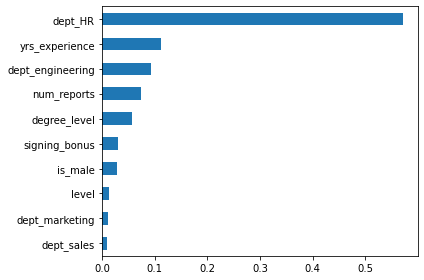

In [25]:
#Let's check variable importance
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop('salary', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')

It looks like the model is essentially just using dept and, to a lesser extent, num_reports, degree_level, and yrs_experience. All other variables are fairly irrelevant.

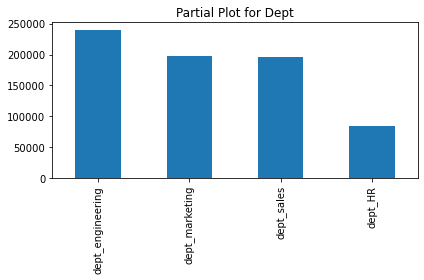

In [26]:
#Let's check partial dependence plots of the top 2 variables: dept and yrs_experience, as well as sex
from pdpbox import pdp, info_plots
  
#dept
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('salary', axis=1),      
                          model_features=list(train.drop('salary', axis=1)), 
                          feature=['dept_HR', 'dept_engineering', 'dept_marketing', 'dept_sales'], 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for Dept')


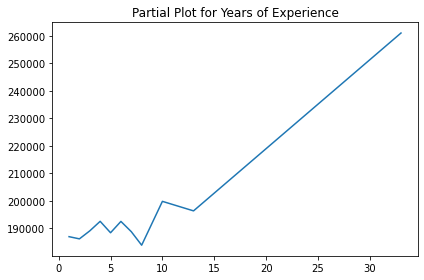

In [27]:
#yrs_experience
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('salary', axis=1),      
                          model_features=list(train.drop('salary', axis=1)), 
                          feature='yrs_experience', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Partial Plot for Years of Experience')

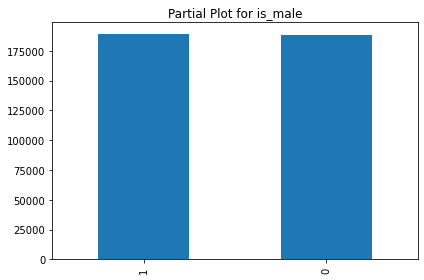

In [28]:
#is_male
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('salary', axis=1),      
                          model_features=list(train.drop('salary', axis=1)), 
                          feature='is_male', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.sort_values(ascending=False).plot(kind='bar',title='Partial Plot for is_male')

Department is definitely the main driver of salary. The difference between HR and Engineering is very large.
Years of experience matters too, but less (note the smaller y range compared to dept). Most importantly, experience seems to matter more past a certain number. That is, salary will start going up after you become fairly senior. Within the first years, it doesn’t have much of an impact taken independently -> to make a lot of money you need to get to a very senior position.
Sex doesn’t appear to matter.


Q: Describe the main factors impacting employee salaries. Do you think the company has been treating all its employees fairly? What are the next steps you would suggest to the Head of HR?


Let’s focus on the variable sex here. We already saw from the partial plot that it doesn’t matter to predict salary. However, the average salary between males and females is pretty different.

In [29]:
#avg salary males vs females
print(data.groupby('is_male')['salary'].mean())

is_male
0    171314.518394
1    198876.514445
Name: salary, dtype: float64


This is largely a function of the fact that males are more likely to be working in engineering and less in HR. Indeed, if we look at sex and dept together, we now get very similar salaries by sex (as a side note, we are also proving here that RF works extremely well with variables sharing information).


In [30]:
#avg salary males vs females by dept
print(data.groupby(['dept','is_male'])['salary'].agg({'mean', 'count'}))

                     count           mean
dept        is_male                      
HR          0         1058   84399.810964
            1          636   84827.044025
engineering 0          671  246785.394933
            1         2025  242444.444444
marketing   0          651  192502.304147
            1         1359  195639.440765
sales       0         1181  194618.120237
            1         2418  194207.196030


# Insights

A possible advice could be to try to hire more uniformly across departments. I.e. less females in HR and more in engineering. A next step could be to look into candidate pipeline by dept and see if proportion of hires matches proportion of applicants by sex.

The relationship of years of experience vs salary feels a bit worrisome. The company seems to mostly reward experience at the very top, and not much for mid-level professionals. This might lead to poor retention among mid-level people. Having salary grow more linearly vs years of experience would probably help retain those people more.